In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import json
def load_and_format(in_path):
    out_df = pd.read_json(in_path)  
    out_images = out_df.apply(lambda c_row: [np.stack([c_row['band_1'],c_row['band_2']], -1).reshape((75,75,2))],1)
    out_images = np.stack(out_images).squeeze()
    return out_df, out_images
train_df, train_images = load_and_format('data/train.json')
print('training', train_df.shape, 'loaded', train_images.shape)

training (1604, 5) loaded (1604, 75, 75, 2)


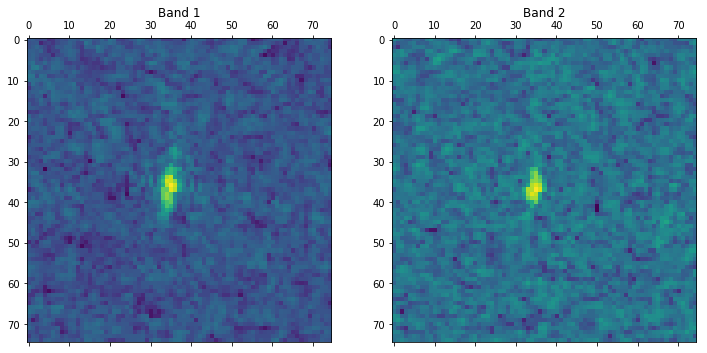

In [3]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))
ax1.matshow(train_images[0,:,:,0])
ax1.set_title('Band 1')
ax2.matshow(train_images[0,:,:,1])
ax2.set_title('Band 2')

In [4]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
X_train, X_test, y_train, y_test = train_test_split(train_images,
                                                   to_categorical(train_df['is_iceberg']),
                                                    random_state = 2017,
                                                    test_size = 0.2
                                                   )
X_train_ang,X_test_ang  = train_test_split(train_df['inc_angle'].replace('na',0) / 50,random_state = 2017,test_size = 0.2)
print('Train', X_train.shape, y_train.shape)
print('Validation', X_test.shape, y_test.shape)

Using TensorFlow backend.


Train (1283, 75, 75, 2) (1283, 2)
Validation (321, 75, 75, 2) (321, 2)


In [5]:
import tensorflow as tf

input_ = tf.placeholder(tf.float32, (None, 75, 75,2), name = 'features')
input_post = tf.placeholder(tf.float32, (None,1), name = 'features2')
label = tf.placeholder(tf.int32, (None, 2), name = 'labels')
keep_prob = tf.placeholder(tf.float32)
is_train = tf.placeholder(tf.bool)

In [6]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [7]:
def conv2d(x, conv_filter, stride, padding):
    return tf.nn.conv2d(x, conv_filter, strides = [1, stride, stride, 1], padding = padding)

def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape)

    # Create new biases, one for each filter.
    biases = new_biases(num_filters)
    
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    layer = tf.nn.relu(layer)

    return layer

In [8]:
num_channels = 2
# Convolutional Layer 1.
filter_size1 = 3          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 3          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Convolutional Layer 3
filter_size3 = 3          # Convolution filters are 5 x 5 pixels.
num_filters3 = 64         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

In [9]:
def CNN(x):
    #batch_norm = tf.layers.batch_normalization(x, training=is_train)
    
    layer_conv1 = new_conv_layer(input=x,
                       num_input_channels=num_channels,
                       filter_size=filter_size1,
                       num_filters=num_filters1,
                       use_pooling=False)
    layer_conv1 = new_conv_layer(input=layer_conv1,
                       num_input_channels=num_filters1,
                       filter_size=filter_size1,
                       num_filters=num_filters1,
                       use_pooling=True)
    drop_conv1 = tf.nn.dropout(layer_conv1, 0.75 + keep_prob*0.25)
    
    layer_conv2 = new_conv_layer(input=drop_conv1,
                       num_input_channels=num_filters1,
                       filter_size=filter_size2,
                       num_filters=num_filters2,
                       use_pooling=False)
    layer_conv2 = new_conv_layer(input=layer_conv2,
                       num_input_channels=num_filters2,
                       filter_size=filter_size2,
                       num_filters=num_filters2,
                       use_pooling=True)
    drop_conv2 = tf.nn.dropout(layer_conv2, 0.85 + keep_prob*0.15)
    
    layer_conv3 = new_conv_layer(input=drop_conv2,
                       num_input_channels=num_filters2,
                       filter_size=filter_size3,
                       num_filters=num_filters3,
                       use_pooling=True)
    drop_conv3 = tf.nn.dropout(layer_conv3, 0.90 + keep_prob*0.10)

    # Shortcut
    #flatten_layer = tf.contrib.layers.flatten(max_pool2)
    #fc = tf.contrib.layers.full_connected(flatten_layer, 256)
    
    # Long way of doing the fully_connected_layer
    _, height, width, depth = drop_conv3.shape
    tensor_size = int(height * width * depth +1) 
    flatten_layer = tf.reshape(drop_conv3, [-1, tensor_size-1])
    
    fc1_hidden_unit = 350
    drop_fc1 = tf.nn.dropout(flatten_layer, 0.58 + keep_prob*0.42)
    drop_feat = tf.concat( [drop_fc1, input_post ], 1 )
    W_fc1 = new_weights([tensor_size, fc1_hidden_unit])
    b_fc1 = new_biases(fc1_hidden_unit)
    
    fc1 = tf.nn.relu(tf.add(tf.matmul(drop_feat, W_fc1), b_fc1))
    drop_fc2 = tf.nn.dropout(fc1, 0.85 + 0.15*keep_prob)
    
    n_class = 2
    W_fc2 = new_weights([fc1_hidden_unit, n_class])
    b_fc2 = new_biases(n_class)
                     
    logits = tf.add(tf.matmul(drop_fc2, W_fc2), b_fc2)
    
    return logits

In [10]:
#tf.reset_default_graph()
logits = CNN(input_)
logits_soft =tf.nn.softmax(logits)

In [11]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels = label, logits = logits)
#error = tf.square(label-logits)/2
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer().minimize(loss)

In [12]:
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(label, 1)), tf.float32))
#auc = tf.metrics.auc(label,logits_soft)

In [13]:
def create_batches(x, y, n_batch, batch_size):
    if (n_batch + 1) * batch_size > x.shape[0]:
        end_idx = n_batch * batch_size
    else:
        end_idx = (n_batch + 1) * batch_size
    
    return(x[:end_idx].reshape(-1, batch_size, 75, 75, 2), y[:end_idx].reshape(-1, batch_size, 2))
def create_batches_2(y, n_batch, batch_size):
    if (n_batch + 1) * batch_size > y.shape[0]:
        end_idx = n_batch * batch_size
    else:
        end_idx = (n_batch + 1) * batch_size
    
    return y[:end_idx].reshape(-1, batch_size, 1)

In [14]:
epoch = 15
batch_size = 32
n_batch = int(np.floor(X_train.shape[0] / batch_size))

sess = tf.Session()

sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
best_accuracy,min_loss = 0,10

In [16]:
for e in range(50):
    print('Epoch {0}'.format(e))
    batch_x, batch_y = create_batches(X_train, y_train, n_batch, batch_size)
    batch_x2= create_batches_2(X_train_ang, n_batch, batch_size)
    for batch in range(n_batch):
        sess.run([optimizer, loss], feed_dict = {input_: batch_x[batch],
                                                 label: batch_y[batch],
                                                 input_post:batch_x2[batch],
                                                 keep_prob:0.0,
                                                 is_train:True} )
        
        if batch % 40 == 0:
            val_feed_dict = {input_: X_test,
                             label: y_test,
                             input_post:X_test_ang.values.reshape([-1,1]),
                             keep_prob:1,
                             is_train:False}
            val_loss = sess.run(loss, feed_dict = val_feed_dict)
            val_acc = accuracy.eval(feed_dict = val_feed_dict,session=sess)
            
            if val_acc > best_accuracy:
                best_accuracy = val_acc
                saver.save(sess, 'models/my_model_acc')
                imp_str_acc = '*'*4
            else:
                imp_str_acc = ''
            if val_loss<min_loss:
                min_loss = val_loss
                saver.save(sess, 'models/my_model_loss')
                imp_str_loss = '*'*4
            else:
                imp_str_loss = ''
                        
           
            print("Batch #{}: Valditaion Loss: {:.3}{}, Validation Accuracy: {:.3}{}"\
                  .format(batch, val_loss,imp_str_loss, val_acc, imp_str_acc))

Epoch 0
Batch #0: Valditaion Loss: 0.329, Validation Accuracy: 0.882


/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:14: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


Epoch 1
Batch #0: Valditaion Loss: 0.313, Validation Accuracy: 0.879
Epoch 2
Batch #0: Valditaion Loss: 0.354, Validation Accuracy: 0.872
Epoch 3
Batch #0: Valditaion Loss: 0.301, Validation Accuracy: 0.882
Epoch 4
Batch #0: Valditaion Loss: 0.3, Validation Accuracy: 0.894
Epoch 5
Batch #0: Valditaion Loss: 0.297, Validation Accuracy: 0.9****
Epoch 6
Batch #0: Valditaion Loss: 0.354, Validation Accuracy: 0.882
Epoch 7
Batch #0: Valditaion Loss: 0.339, Validation Accuracy: 0.894
Epoch 8
Batch #0: Valditaion Loss: 0.322, Validation Accuracy: 0.897
Epoch 9
Batch #0: Valditaion Loss: 0.36, Validation Accuracy: 0.879
Epoch 10
Batch #0: Valditaion Loss: 0.313, Validation Accuracy: 0.891
Epoch 11
Batch #0: Valditaion Loss: 0.347, Validation Accuracy: 0.897
Epoch 12
Batch #0: Valditaion Loss: 0.425, Validation Accuracy: 0.879
Epoch 13
Batch #0: Valditaion Loss: 0.441, Validation Accuracy: 0.875
Epoch 14
Batch #0: Valditaion Loss: 0.342, Validation Accuracy: 0.894
Epoch 15
Batch #0: Valditaion 

KeyboardInterrupt: 

In [22]:
pred = sess.run(logits_soft, feed_dict = val_feed_dict)

In [23]:
np.round(pred[:10],3)

array([[ 0.        ,  1.        ],
       [ 0.001     ,  0.99900001],
       [ 0.        ,  1.        ],
       [ 0.        ,  1.        ],
       [ 1.        ,  0.        ],
       [ 0.        ,  1.        ],
       [ 0.99199998,  0.008     ],
       [ 1.        ,  0.        ],
       [ 0.29899999,  0.70099998],
       [ 0.        ,  1.        ]], dtype=float32)

In [24]:
test_df, test_imgages = load_and_format('data/test.json')
print('ok')

ok


In [25]:
inc_ang = test_df['inc_angle'].replace('na',0) / 50
inc_ang = inc_ang.as_matrix().reshape([-1,1])

In [26]:
feed_dict_sub1 = {input_: test_imgages[:4000], input_post:inc_ang[:4000], keep_prob:1,is_train:False} 
feed_dict_sub2 = {input_: test_imgages[4000:], input_post:inc_ang[4000:], keep_prob:1,is_train:False} 

In [27]:
saver.restore(sess,"models/my_model_loss")
sub_loss1 = sess.run(logits_soft,feed_dict=feed_dict_sub1)
sub_loss2 = sess.run(logits_soft,feed_dict=feed_dict_sub2)
saver.restore(sess,"models/my_model_acc")
sub_acc1 = sess.run(logits_soft,feed_dict=feed_dict_sub1)
sub_acc2 = sess.run(logits_soft,feed_dict=feed_dict_sub2)

INFO:tensorflow:Restoring parameters from models/my_model_loss
INFO:tensorflow:Restoring parameters from models/my_model_acc


In [28]:
sub_loss = np.append(sub_loss1,sub_loss2,axis=0)
sub_acc = np.append(sub_acc1,sub_acc2,axis=0)


In [29]:
sub_loss = [1-p[0] if np.argmax(p)==0 else p[1]  for p in sub_loss]
sub_acc = [1-p[0] if np.argmax(p)==0 else p[1]  for p in sub_acc]
sub_data = (np.array(sub_loss) + np.array(sub_acc))/2

In [30]:
sub = pd.DataFrame()
sub['id'] = test_df['id']
sub['is_iceberg'] = sub_data

In [31]:
sub.to_csv("sub/sub_loss{:.3}_acc{:.3}.csv".format(min_loss,best_accuracy), index = False)

In [32]:
len(sub)

8424